# 1. Data Import and Preprocessing

## 1.1 Load the sensor dataset with pd.read_csv，and generate the dataframe.

In [9]:
import pandas as pd
import numpy as np

data_path ='./Datasets/dataset_new.csv'
columns_name = ('date', 'time', 'sensor_id', 'value', 'activity', 'status') # status是begin或end
df = pd.read_csv(data_path, names = columns_name)

In [10]:
df.dtypes

date         object
time         object
sensor_id    object
value        object
activity     object
status       object
dtype: object

In [11]:
'''
# Testing
df.iloc[:,:4]
df_first4Attr = df.iloc[:,:4]
df[df_first4Attr.isnull().values==True]
'''

'\n# Testing\ndf.iloc[:,:4]\ndf_first4Attr = df.iloc[:,:4]\ndf[df_first4Attr.isnull().values==True]\n'

In [12]:
# Check how many sensors in total.
df['sensor_id'].unique()

array(['M35', 'AD1-A', 'M34', 'M32', 'M33', 'M36', 'M30', 'M29', 'M37',
       'M38', 'M39', 'M41', 'M40', 'M49', 'M46', 'M50', 'M44', 'M47',
       'M48', 'M43', 'M28', 'M42', 'M27', 'M26', 'M25', 'M24', 'M21',
       'M19', 'M18', 'M17', 'M16', 'M15', 'D09', 'M14', 'M13', 'M08',
       'M07', 'M02', 'M45', 'M51', 'D08', 'AD1-B', 'AD1-C', 'D10', 'I03',
       'M06', 'M09', 'M10', 'M01', 'D12', 'L04', 'M23', 'M31', 'D15',
       'D07', 'D14', 'M11', 'M05', 'M03', 'M04', 'M22', 'M12', 'M20',
       'L11', 'D05', 'D03', 'L10', 'L06', 'L13', 'L12', 'L09'],
      dtype=object)

## 1.2 Determine the missing values of the sensor dataframe.

In [14]:
df.dropna(axis=0, how='all', inplace=True) ## Drop the lines containing NA values.
df

,date,time,sensor_id,value,activity,status
0,02/02/2009,7:15:17,M35,ON,R1_Bed_to_Toilet,begin
1,02/02/2009,7:15:21,AD1-A,2.82231,NaN,NaN
2,02/02/2009,7:15:23,M35,OFF,NaN,NaN
3,02/02/2009,7:15:23,M35,ON,NaN,NaN
4,02/02/2009,7:15:28,AD1-A,2.79926,NaN,NaN
...,...,...,...,...,...,...
138625,04/04/2009,7:26:16,M48,OFF,NaN,NaN
138626,04/04/2009,7:27:47,M48,ON,NaN,NaN
138627,04/04/2009,7:27:50,M47,ON,NaN,NaN
138628,04/04/2009,7:27:59,M47,OFF,NaN,NaN


## 1.3 Create a new column "datetime" by combining the "date" and "time"

In [8]:
# df["datetime"] = pd.to_datetime(df["date"] + " "+ df["time"], format='%d/%m/%Y %H:%M:%S')
df["datetime"] = pd.to_datetime(df["date"] + " "+ df["time"], dayfirst=True)


In [16]:
# df = df.set_index("datetime") # Don't set datetime as index! datetime has repeated values!
df # Check status

,date,time,sensor_id,value,activity,status
0,02/02/2009,7:15:17,M35,ON,R1_Bed_to_Toilet,begin
1,02/02/2009,7:15:21,AD1-A,2.82231,NaN,NaN
2,02/02/2009,7:15:23,M35,OFF,NaN,NaN
3,02/02/2009,7:15:23,M35,ON,NaN,NaN
4,02/02/2009,7:15:28,AD1-A,2.79926,NaN,NaN
...,...,...,...,...,...,...
138625,04/04/2009,7:26:16,M48,OFF,NaN,NaN
138626,04/04/2009,7:27:47,M48,ON,NaN,NaN
138627,04/04/2009,7:27:50,M47,ON,NaN,NaN
138628,04/04/2009,7:27:59,M47,OFF,NaN,NaN


In [17]:
# Check the increasing sequence of datetime. last value <= next value
# for a, b in zip(df.datetime, df.datetime[1:]):
#     if(a>b):
#         print(a)
#
# # all(a <= b for a, b in zip(df.index, df.index[1:]))

## 1.4 区分公共事件：对每个公共activity进行处理，统计并比较每一次活动中R1和R2房间内所有传感器的触发总次数，R1比R2触发的多，该公共事件标记为R2做的，否则标记为是R1做的。

结果不好，算了算了，不做了。

In [10]:
'''
# 将"value"列的"ON"和"OPEN"转为1，"OFF"和"CLOSE"转为0

# df["value"].unique() #检查value都有哪些名称

one_vals = ["ON","OPEN", "PRESENT"]
zero_vals = ["OFF","CLOSE", "ABSENT"]

df.loc[df['value'].isin(one_vals), 'value'] = 1
df.loc[df['value'].isin(zero_vals), 'value'] = 0
df
'''


,date,time,sensor_id,value,activity,status,datetime
0,02/02/2009,7:15:17,M35,1,R1_Bed_to_Toilet,begin,2009-02-02 07:15:17
1,02/02/2009,7:15:21,AD1-A,2.82231,NaN,NaN,2009-02-02 07:15:21
2,02/02/2009,7:15:23,M35,0,NaN,NaN,2009-02-02 07:15:23
3,02/02/2009,7:15:23,M35,1,NaN,NaN,2009-02-02 07:15:23
4,02/02/2009,7:15:28,AD1-A,2.79926,NaN,NaN,2009-02-02 07:15:28
...,...,...,...,...,...,...,...
138625,04/04/2009,7:26:16,M48,0,NaN,NaN,2009-04-04 07:26:16
138626,04/04/2009,7:27:47,M48,1,NaN,NaN,2009-04-04 07:27:47
138627,04/04/2009,7:27:50,M47,1,NaN,NaN,2009-04-04 07:27:50
138628,04/04/2009,7:27:59,M47,0,NaN,NaN,2009-04-04 07:27:59


In [11]:
# 检查begin总数==end总数
def check_begin_end_total(df):
    cnt_begin = 0
    cnt_end = 0
    for index,row in df.iterrows():
        if row.status == 'begin':
            cnt_begin += 1
        elif row.status == 'end':
            cnt_end += 1
    print(cnt_begin)
    print(cnt_end)
check_begin_end_total(df)

516
516


In [12]:
# 检查begin-end pair的activities可以相互抵消
def check_activity_symmetry(df):
    stack = []
    cnt = 0
    for index,row in df.iterrows():
        if not pd.isnull(row.activity):
            if row.status == 'begin':
                stack.append(row.activity)
            elif row.status == 'end':
                stack.pop()

        # 每1000次打印一次栈的状态
        cnt += 1
        if cnt % 1000 == 0:
            print(stack)

    print("The final stack value:", stack)

check_activity_symmetry(df)

['Watch_TV']
['R1_Work', 'R2_Work']
['R1_Work']
['Meal_Preparation']
['Meal_Preparation']
['R1_Sleep', 'R2_Sleep']
['Meal_Preparation']
['R2_Work']
['R2_Work', 'R2_Sleep']
['Meal_Preparation']
['R1_Work']
['R1_Work', 'R2_Work']
['R2_Sleep', 'R1_Sleep']
['Meal_Preparation']
['R1_Work', 'Clean']
['Study', 'R1_Work']
['Study', 'R1_Work']
['R1_Sleep', 'R2_Sleep']
['Meal_Preparation']
['R1_Work']
['Watch_TV']
['Watch_TV', 'R2_Sleep']
['R1_Personal_Hygiene']
['Meal_Preparation']
['Meal_Preparation']
['Meal_Preparation']
[]
['Meal_Preparation']
['R1_Work', 'R2_Sleep']
['R1_Work', 'R1_Sleep', 'R1_Bed_to_Toilet']
['R1_Work', 'R2_Personal_Hygiene']
['Meal_Preparation', 'Watch_TV']
['Meal_Preparation', 'R1_Work']
['Meal_Preparation', 'R1_Work']
['Meal_Preparation', 'R1_Sleep']
['Watch_TV', 'Meal_Preparation']
['Watch_TV', 'Meal_Preparation']
['Watch_TV', 'R1_Work', 'R2_Work']
['R1_Sleep', 'R2_Sleep']
['Meal_Preparation']
['R1_Sleep', 'R2_Work']
['R1_Sleep', 'R1_Work']
['Meal_Preparation']
['Meal_

In [13]:
df

,date,time,sensor_id,value,activity,status,datetime
0,02/02/2009,7:15:17,M35,1,R1_Bed_to_Toilet,begin,2009-02-02 07:15:17
1,02/02/2009,7:15:21,AD1-A,2.82231,NaN,NaN,2009-02-02 07:15:21
2,02/02/2009,7:15:23,M35,0,NaN,NaN,2009-02-02 07:15:23
3,02/02/2009,7:15:23,M35,1,NaN,NaN,2009-02-02 07:15:23
4,02/02/2009,7:15:28,AD1-A,2.79926,NaN,NaN,2009-02-02 07:15:28
...,...,...,...,...,...,...,...
138625,04/04/2009,7:26:16,M48,0,NaN,NaN,2009-04-04 07:26:16
138626,04/04/2009,7:27:47,M48,1,NaN,NaN,2009-04-04 07:27:47
138627,04/04/2009,7:27:50,M47,1,NaN,NaN,2009-04-04 07:27:50
138628,04/04/2009,7:27:59,M47,0,NaN,NaN,2009-04-04 07:27:59


In [14]:
df.loc[[0,1,2],["activity","status"]]

,activity,status
0,R1_Bed_to_Toilet,begin
1,NaN,NaN
2,NaN,NaN


In [15]:
df["sensor_id"].unique()

array(['M35', 'AD1-A', 'M34', 'M32', 'M33', 'M36', 'M30', 'M29', 'M37',
       'M38', 'M39', 'M41', 'M40', 'M49', 'M46', 'M50', 'M44', 'M47',
       'M48', 'M43', 'M28', 'M42', 'M27', 'M26', 'M25', 'M24', 'M21',
       'M19', 'M18', 'M17', 'M16', 'M15', 'D09', 'M14', 'M13', 'M08',
       'M07', 'M02', 'M45', 'M51', 'D08', 'AD1-B', 'AD1-C', 'D10', 'I03',
       'M06', 'M09', 'M10', 'M01', 'D12', 'L04', 'M23', 'M31', 'D15',
       'D07', 'D14', 'M11', 'M05', 'M03', 'M04', 'M22', 'M12', 'M20',
       'L11', 'D05', 'D03', 'L10', 'L06', 'L13', 'L12', 'L09'],
      dtype=object)

In [16]:

# 处理公共事件
# 结果不好，算了算了，不做了。
common_activities_list = ["Meal_Preparation", "Watch_TV", "Wash_Bathtub", "Clean", "Study"]
R1_room_sensor_list = ["M30","M31","M32","M33","M34","M35","M36","I03"]
R2_room_sensor_list = ["M43","M44","M45","M46","M47","M48","M49","M50"]

for index,row in df.iterrows():
    if row["activity"] in common_activities_list:
        if row.status == 'begin':
            tmp_index = index
            R1_room_sensor_cnt = 0
            R2_room_sensor_cnt = 0
            while (df.loc[tmp_index, "activity"] != row["activity"]) or (df.loc[tmp_index, "status"] != "end"):
                if (df.loc[tmp_index, "sensor_id"] in R1_room_sensor_list) and (df.loc[tmp_index, "value"] == 1):
                    R1_room_sensor_cnt += 1
                if (df.loc[tmp_index, "sensor_id"] in R2_room_sensor_list) and (df.loc[tmp_index, "value"] == 1):
                    R2_room_sensor_cnt += 1
                tmp_index += 1
            # 因为在while循环到end结束后，end那一行的数据还没有被循环到，所以要再增加一行
            if (df.loc[tmp_index, "sensor_id"] in R1_room_sensor_list) and (df.loc[tmp_index, "value"] == 1):
                    R1_room_sensor_cnt += 1
            if (df.loc[tmp_index, "sensor_id"] in R2_room_sensor_list) and (df.loc[tmp_index, "value"] == 1):
                R2_room_sensor_cnt += 1

            # 开始改名
            print(R1_room_sensor_cnt, R2_room_sensor_cnt)
            new_name = ""
            if R1_room_sensor_cnt > R2_room_sensor_cnt:
                print("对activity"+row.activity+", R1房间传感器触发大于R2房间")
                new_name = "R2_" + row["activity"]
            elif R1_room_sensor_cnt == R2_room_sensor_cnt:
                print("对activity"+row.activity+", R1房间传感器触发等于R2房间")
                new_name = "R1_" + row["activity"]
            else:
                print("对activity"+row.activity+", R1房间传感器触发小于R2房间")
                new_name = "R1_" + row["activity"]

            tmp_index = index
            while (df.loc[tmp_index, "activity"] != row["activity"]) or (df.loc[tmp_index, "status"] != "end"):
                tmp_index += 1

            df.loc[index, "activity"] = new_name # 给begin重命名
            df.loc[tmp_index, "activity"] = new_name # 给end重命名


0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
1 0
对activityWatch_TV, R1房间传感器触发大于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
117 0
对activityWatch_TV, R1房间传感器触发大于R2房间
12 0
对activityMeal_Preparation, R1房间传感器触发大于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
1 0
对activityWatch_TV, R1房间传感器触发大于R2房间
0 9
对activityWash_Bathtub, R1房间传感器触发小于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityWatch_TV, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
13 0
对activityMeal_Preparation, R1房间传感器触发大于R2房间
0 2
对activityMeal_Preparation, R1房间传感器触发小于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 0
对activityMeal_Preparation, R1房间传感器触发等于R2房间
0 84
对activityClean, R1房间传感器触发小于R2房间
380 0
对a

In [17]:
df

,date,time,sensor_id,value,activity,status,datetime
0,02/02/2009,7:15:17,M35,1,R1_Bed_to_Toilet,begin,2009-02-02 07:15:17
1,02/02/2009,7:15:21,AD1-A,2.82231,NaN,NaN,2009-02-02 07:15:21
2,02/02/2009,7:15:23,M35,0,NaN,NaN,2009-02-02 07:15:23
3,02/02/2009,7:15:23,M35,1,NaN,NaN,2009-02-02 07:15:23
4,02/02/2009,7:15:28,AD1-A,2.79926,NaN,NaN,2009-02-02 07:15:28
...,...,...,...,...,...,...,...
138625,04/04/2009,7:26:16,M48,0,NaN,NaN,2009-04-04 07:26:16
138626,04/04/2009,7:27:47,M48,1,NaN,NaN,2009-04-04 07:27:47
138627,04/04/2009,7:27:50,M47,1,NaN,NaN,2009-04-04 07:27:50
138628,04/04/2009,7:27:59,M47,0,NaN,NaN,2009-04-04 07:27:59


## 1.5 给begin-end包围的activity打标签，begin-end之外的标为"other"，嵌套的按照最近的begin-end来标，标完之后删掉begin、end这一列。

In [18]:
# 对activity填值：begin-end中间填最近的activity，begin-end外填other

# def set_activity(df):
stack = []
cnt = 0
for index,row in df.iterrows():
    if not pd.isnull(row["activity"]):
#         print("yes activity!", row.activity)
#         print(cnt)
        if row.status == 'begin':
            stack.append(row.activity)
        elif row.status == 'end':
            del(stack[stack.index(row.activity)])
    else:
        # 判断有没有被begin-end包围
        if len(stack) == 0:
            df.loc[index, 'activity'] = "other"
        else:
            df.loc[index, 'activity'] = stack[-1]

    cnt += 1
    # return df

df

,date,time,sensor_id,value,activity,status,datetime
0,02/02/2009,7:15:17,M35,1,R1_Bed_to_Toilet,begin,2009-02-02 07:15:17
1,02/02/2009,7:15:21,AD1-A,2.82231,R1_Bed_to_Toilet,NaN,2009-02-02 07:15:21
2,02/02/2009,7:15:23,M35,0,R1_Bed_to_Toilet,NaN,2009-02-02 07:15:23
3,02/02/2009,7:15:23,M35,1,R1_Bed_to_Toilet,NaN,2009-02-02 07:15:23
4,02/02/2009,7:15:28,AD1-A,2.79926,R1_Bed_to_Toilet,NaN,2009-02-02 07:15:28
...,...,...,...,...,...,...,...
138625,04/04/2009,7:26:16,M48,0,R2_Sleep,NaN,2009-04-04 07:26:16
138626,04/04/2009,7:27:47,M48,1,R2_Sleep,NaN,2009-04-04 07:27:47
138627,04/04/2009,7:27:50,M47,1,R2_Sleep,NaN,2009-04-04 07:27:50
138628,04/04/2009,7:27:59,M47,0,R2_Sleep,NaN,2009-04-04 07:27:59


## 1.6 将sensor_id和activities转为数值，用于模型训练

In [19]:
from sklearn.preprocessing import LabelEncoder

# 对sensor进行labelEncoder
sensor_encoder = LabelEncoder()
sensor_encoder.fit(df.sensor_id)

# 对activity进行labelEncoder
activity_encoder = LabelEncoder()
activity_encoder.fit(df.activity.astype(str))

df.sensor_id = sensor_encoder.transform(df.sensor_id)
df.activity = activity_encoder.transform(df.activity.astype(str))

In [20]:
#输出label encoder编码后的值
print(sorted(df.sensor_id.unique()))
print(sorted(df.activity.unique()))

#查看数字对应的原始名字
print(sensor_encoder.inverse_transform(sorted(df.sensor_id.unique())))
print(activity_encoder.inverse_transform(sorted(df.activity.unique())))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
['AD1-A' 'AD1-B' 'AD1-C' 'D03' 'D05' 'D07' 'D08' 'D09' 'D10' 'D12' 'D14'
 'D15' 'I03' 'L04' 'L06' 'L09' 'L10' 'L11' 'L12' 'L13' 'M01' 'M02' 'M03'
 'M04' 'M05' 'M06' 'M07' 'M08' 'M09' 'M10' 'M11' 'M12' 'M13' 'M14' 'M15'
 'M16' 'M17' 'M18' 'M19' 'M20' 'M21' 'M22' 'M23' 'M24' 'M25' 'M26' 'M27'
 'M28' 'M29' 'M30' 'M31' 'M32' 'M33' 'M34' 'M35' 'M36' 'M37' 'M38' 'M39'
 'M40' 'M41' 'M42' 'M43' 'M44' 'M45' 'M46' 'M47' 'M48' 'M49' 'M50' 'M51']
['Clean' 'Meal_Preparation' 'R1_Bed_to_Toilet' 'R1_Personal_Hygiene'
 'R1_Sleep' 'R1_Work' 'R2_Bed_to_Toilet' 'R2_Personal_Hygiene' 'R2_Sleep'
 'R2_Work' 'Study' 'Wash_Bathtub' 'Watch_TV' 'other']


In [21]:
df

,date,time,sensor_id,value,activity,status,datetime
0,02/02/2009,7:15:17,54,1,2,begin,2009-02-02 07:15:17
1,02/02/2009,7:15:21,0,2.82231,2,NaN,2009-02-02 07:15:21
2,02/02/2009,7:15:23,54,0,2,NaN,2009-02-02 07:15:23
3,02/02/2009,7:15:23,54,1,2,NaN,2009-02-02 07:15:23
4,02/02/2009,7:15:28,0,2.79926,2,NaN,2009-02-02 07:15:28
...,...,...,...,...,...,...,...
138625,04/04/2009,7:26:16,67,0,8,NaN,2009-04-04 07:26:16
138626,04/04/2009,7:27:47,67,1,8,NaN,2009-04-04 07:27:47
138627,04/04/2009,7:27:50,66,1,8,NaN,2009-04-04 07:27:50
138628,04/04/2009,7:27:59,66,0,8,NaN,2009-04-04 07:27:59


## 1.7构建mutual matrix

In [22]:
## mutual源代码
# def calculate_mutual_info_matrix(self, mutual_matrix, sensnum):
#     current_activity = self.data.iloc[0].activity1
#     wind = []
#     winds=[]
#     winnum = 0
#
#     for idx, row in self.data.iterrows():
#         if current_activity == row.activity1:
#             wind.append(row.sensor_id)
#         else:
#             sensors = np.unique(wind)
#             for sensor in range(0, sensnum):
#                 for sensor2 in range(0, sensnum):
#                     if sensor in sensors and sensor2 in sensors:
#                         mutual_matrix[sensor][sensor2] += 1
#                         winds.append(wind)
#             winnum += 1
#             current_activity = row.activity1
#             wind = [row.sensor_id]
#
#     return mutual_matrix/winnum
#
# mutual_matrix = self.calculate_mutual_info_matrix(np.zeros((self.sens_num, self.sens_num)),
#                                                                    self.sens_num)

In [23]:
## 构建mutual矩阵-->在数据集activities的前提下，传感器之间的关系
current_activity = df.iloc[0].activity
wind = []
winds=[]
winnum = 0

sens_num = len(df.sensor_id.unique()) # 71
mutual_matrix = np.zeros((sens_num, sens_num))
sensnum = sens_num

for idx, row in df.iterrows():
        # 以当前事件作为判断
        if current_activity == row.activity:
            # 窗口增加：当前行的sensor_id
            # 将与当前事件相关的sensor依次录入wind窗口
            wind.append(row.sensor_id)
        # 首次出现非当前事件-即下个activity
        else:
            # 将窗口里的独特的sensor_id进行排序
            sensors = np.unique(wind)
            # 将当前事件涉及的sensor_id(unique)填入对称的mutual矩阵里
            for sensor in range(0, sensnum):
                for sensor2 in range(0, sensnum):
                    if sensor in sensors and sensor2 in sensors:
                        mutual_matrix[sensor][sensor2] += 1
                        winds.append(wind)
            # 事件数+1
            winnum += 1
            # 重置当前事件
            current_activity = row.activity
            # 重置wind窗口
            wind = [row.sensor_id]

mutual_matrix = mutual_matrix/winnum

In [24]:
mutual_matrix

array([[0.13372781, 0.09467456, 0.04378698, ..., 0.00236686, 0.00828402,
        0.10650888],
       [0.09467456, 0.13727811, 0.0556213 , ..., 0.00236686, 0.00591716,
        0.12307692],
       [0.04378698, 0.0556213 , 0.05680473, ..., 0.        , 0.00118343,
        0.05325444],
       ...,
       [0.00236686, 0.00236686, 0.        , ..., 0.06745562, 0.04615385,
        0.00591716],
       [0.00828402, 0.00591716, 0.00118343, ..., 0.04615385, 0.1147929 ,
        0.00591716],
       [0.10650888, 0.12307692, 0.05325444, ..., 0.00591716, 0.00591716,
        0.15502959]])

In [25]:
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # correlation_heatmap = sns.heatmap(cm,linewidths=0.5)
    # figure = correlation_heatmap.get_figure()
    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.imshow(cm, cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, format(cm[i, j], fmt),
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


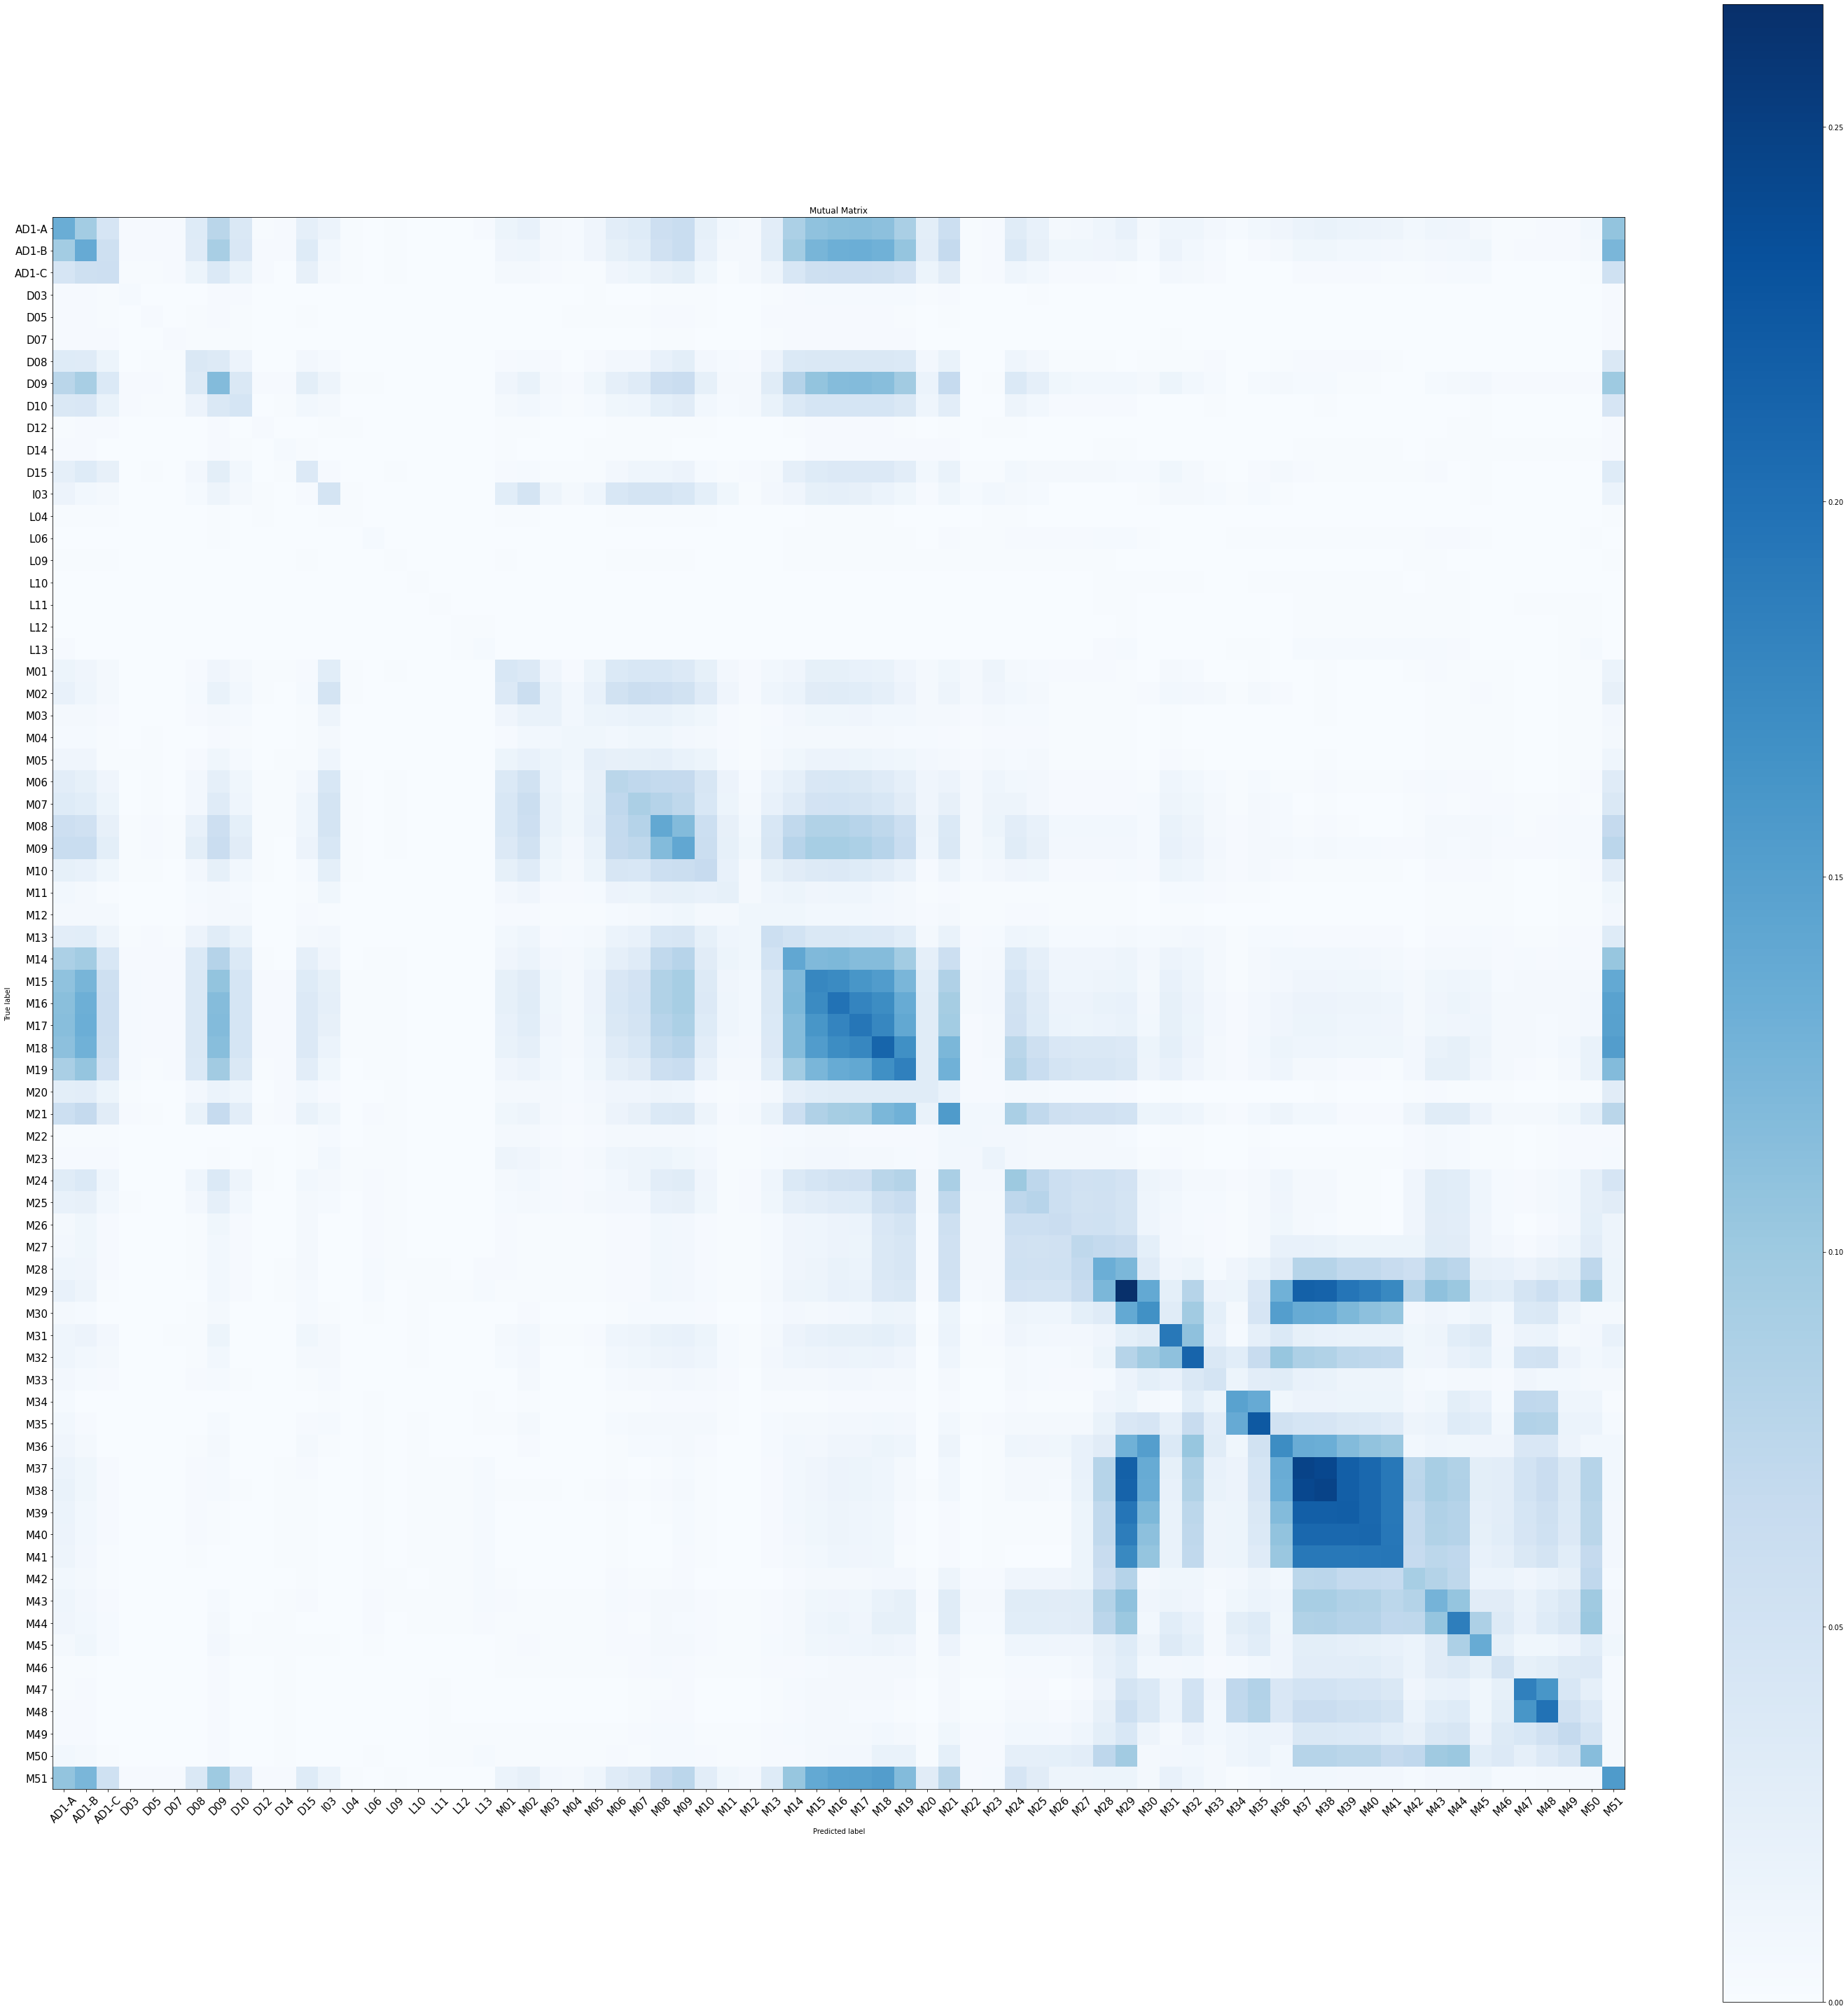

In [47]:
plt.figure(figsize=(40, 40))
plot_confusion_matrix(mutual_matrix, classes=sensor_encoder.inverse_transform(sorted(df.sensor_id.unique())), normalize=False, title='Mutual Matrix')
plt.tick_params(labelsize = 15)
plt.savefig("images_ActivityRecognition/confusion_matrix.pdf")
plt.show()

## 1.8构建滑动窗口

In [29]:
# from datetime import datetime
# idx = 0
# sliding_window_length = 6
# windows = df.iloc[idx:idx + sliding_window_length]
# windows

In [30]:
# last_activity = windows.iloc[sliding_window_length-1].activity
# 
# start_time = windows.iloc[0].datetime
# last_time = windows.iloc[sliding_window_length - 1].datetime
# last_time = datetime(last_time.year, last_time.month, last_time.day, last_time.hour, last_time.minute,
#                              last_time.second)
# start_time = datetime(start_time.year, start_time.month, start_time.day, start_time.hour, start_time.minute,
#                       start_time.second)
# last_time = last_time.hour / 24  + last_time.minute / 60. + last_time.second / 3600.
# start_time = start_time.hour / 24 + start_time.minute / 60. + start_time.second / 3600.
# print(start_time)
# print(last_time)

In [31]:
# last_sensor_id = windows.iloc[sliding_window_length - 1].sensor_id
# second_last_id = windows.iloc[sliding_window_length - 2].sensor_id
# print(last_sensor_id)
# print(second_last_id)

In [32]:
# sens_num = len(df.sensor_id.unique()) # 71
# freq = np.zeros(sens_num)
# for ind, act in windows.iterrows():
#     freq[int(act.sensor_id)] += 1
# print(freq)

In [33]:
from datetime import datetime
sliding_window_length = 130
# 30: 92.9329% 94.2965%; 80:96.3623% 97.7589%; 100: 97.412%, 98.581% 120：0.9794， 0.9901; 130: 0.981552, (0.991155 for n_estimator = 100, 0.9917 for n_estimator = 300)
windows_vectors, activities_vectors = [], [],
for idx in range(0, df.shape[0], 1):  #[0,139629]
    current_sens = []
    if df.shape[0] <= idx + sliding_window_length:
        break

    sens_num = len(df.sensor_id.unique()) # 71
    freq = np.zeros(sens_num)
    # 取前sliding_window_length行作为windows
    windows = df.iloc[idx:idx + sliding_window_length]
    # 窗口里最后一行的事件
    last_activity = windows.iloc[sliding_window_length-1].activity

    # 将窗口里开始时间和结束时间转为0~1的值
    start_time = windows.iloc[0].datetime
    last_time = windows.iloc[sliding_window_length - 1].datetime
    last_time = datetime(last_time.year, last_time.month, last_time.day, last_time.hour, last_time.minute,
                                 last_time.second)
    start_time = datetime(start_time.year, start_time.month, start_time.day, start_time.hour, start_time.minute,
                          start_time.second)
    last_time = last_time.hour / 24  + last_time.minute / (60. * 24) + last_time.second / (3600. * 24)
    start_time = start_time.hour / 24 + start_time.minute / (60. * 24)  + start_time.second / (3600. * 24)

    last_sensor_id = windows.iloc[sliding_window_length - 1].sensor_id
    # !!!感觉好像没理由用second_last_id, 调参时考虑把它注释掉试试
    second_last_id = windows.iloc[sliding_window_length - 2].sensor_id

    # 记录窗口中每个sensor_id出现的次数
    for ind, act in windows.iterrows():
        freq[int(act.sensor_id)] += 1

    #weighting frequencies using mutual matrix table
    # 按窗口中最后一行的传感器相关性
    for ind, val in enumerate(freq):
        freq[ind] = freq[ind] * mutual_matrix[last_sensor_id][ind]

    # 解决极端情况: last_time = 0.0001 start_time = 0.99999999
    if last_time >= start_time:
        timespan = last_time - start_time
    else:
        timespan = (last_time + 1) - start_time

    if(timespan < 0):
        print("Time span < 0! Error!")


    freq = np.append(freq, (last_time, timespan, second_last_id, last_sensor_id)) # 模型输入维度71+4

    windows_vectors.append(freq)
    activities_vectors.append(last_activity) # last_activity 作为label

In [34]:
# windows_vectors

In [35]:
# activities_vectors

In [36]:
    # def get_segments(self):
    #     windows_vectors, activities_vectors = [], [],
    #
    #     for idx in range(0, self.data.shape[0], 1):
    #         current_sens = []
    #         if self.data.shape[0] <= idx + self.sliding_window_length:
    #             break
    #
    #         freq = np.zeros(self.sens_num)
    #         windows = self.data.iloc[idx:idx + self.sliding_window_length]
    #         last_activity = windows.iloc[self.sliding_window_length - 1].activity1
    #
    #         start_time = windows.iloc[0].datetime
    #         last_time = windows.iloc[self.sliding_window_length - 1].datetime
    #         last_time = datetime(last_time.year, last_time.month, last_time.day, last_time.hour, last_time.minute,
    #                              last_time.second)
    #         start_time = datetime(start_time.year, start_time.month, start_time.day, start_time.hour, start_time.minute,
    #                               start_time.second)
    #         last_time = last_time.hour / 24  + last_time.minute / 60. + last_time.second / 3600.
    #         start_time = start_time.hour / 24 + start_time.minute / 60. + start_time.second / 3600.
    #         last_sensor_id = windows.iloc[self.sliding_window_length - 1].sensor_id
    #         second_last_id = windows.iloc[self.sliding_window_length - 2].sensor_id
    #
    #         for ind, act in windows.iterrows():
    #             freq[int(act.sensor_id)] += 1
    #
    #         #weighting frequencies using mutual matrix table
    #         for ind, val in enumerate(freq):
    #             freq[ind] = freq[ind] * self.mutual_matrix[last_sensor_id][ind]
    #
    #         timespan = last_time - start_time
    #         freq = np.append(freq, (last_time, timespan, second_last_id, last_sensor_id))
    #
    #         windows_vectors.append(freq)
    #         activities_vectors.append(last_activity)
    #
    #     return np.array(windows_vectors), np.array(activities_vectors)

## 1.9划分训练测试集

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    windows_vectors, activities_vectors, test_size=0.2, random_state=42)

In [38]:
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(110800, 75)
(110800,)
(27700, 75)
(27700,)


# 2. 构建模型

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from numpy import random
from matplotlib import pyplot as plt
import os

# Below command is used to fix the bug when generating visualized tree in RF.
# only for Windows system.
# os.environ["PATH"] += os.pathsep + "D:/Graphviz/bin/" #记得改文件位置



def DecisionTree_Classifier(x_train, x_valid_test, y_train, y_valid_test):
    """
    First take the training set, and valid or test set as inputs.
    Then classify them binary with DT. Print the information related to classification accuracy.
    Inputs:
        x_train: Preprocessed brain MRI images as inputs to train a model.
        y_train: Label information of x_train as inputs to train a model.
        x_valid_test: Preprocessed brain MRI images to validate or test the classification accuracy of the trained model.
                    The preprocessing of valid or test sets cannot use any information of x_train or y_train.
        y_valid: Label information of valid or test sets to calculate the classification accuracy of the trained model.
    Outputs:
        accu: Accuracy of the model on valid or test set.
        y_pred: Predicted labels on valid or test set.
    """
    # Create RF classifier.
    rf = DecisionTreeClassifier()
    rf.fit(x_train, y_train)  # Fit RF model

    # Plot one of the decision tree
    # text format
    # text_representation = tree.export_text(rf.estimators_[1])
    # print(text_representation)

    # image format
    # ----------------------------------------------------------------
    # dot_data = tree.export_graphviz(rf)
    #
    # graph = graphviz.Source(dot_data)
    # graph.render("DecisionTree")
    # graph.write_pdf("DecisionTree_"+str(seed)+".pdf")
    # ----------------------------------------------------------------

    # Make prediction.
    y_pred = rf.predict(x_valid_test)

    # Print results.
    report = metrics.classification_report(y_valid_test, y_pred)
    # print("Random Forest classification report:\n " + report)
    print("Decision Tree classification report:\n " + report)

    accu = metrics.accuracy_score(y_valid_test, y_pred)
    # print("Random Forest classification accuracy: " + str(accu))
    print("Decision Tree classification accuracy: " + str(accu))

    return accu, y_pred



def RF_Classifier(x_train, x_valid_test, y_train, y_valid_test, feature_names, n_estimators = 100):
    """
    First take the training set, and valid or test set as inputs.
    Then classify them binary with RF. Print the information related to classification accuracy.
    Inputs:
        x_train: Preprocessed brain MRI images as inputs to train a model.
        y_train: Label information of x_train as inputs to train a model.
        x_valid_test: Preprocessed brain MRI images to validate or test the classification accuracy of the trained model.
                    The preprocessing of valid or test sets cannot use any information of x_train or y_train.
        y_valid: Label information of valid or test sets to calculate the classification accuracy of the trained model.
    Outputs:
        accu: Accuracy of the model on valid or test set.
        y_pred: Predicted labels on valid or test set.
    """
    # Create RF classifier.
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    rf.fit(x_train, y_train)  # Fit RF model

    # 画出特征值重要性
    sorted_idx = rf.feature_importances_.argsort()
    feature_importances = rf.feature_importances_

    plt.figure(figsize=(20, 15))
    plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
    plt.xlabel("Random Forest Feature Importance", fontsize = 30)
    plt.tick_params(axis='x', labelsize = 15)
    plt.savefig("images_ActivityRecognition/RFFeatureImportance.pdf")

    # Plot one of the decision tree
    # text format
    # text_representation = tree.export_text(rf.estimators_[1])
    # print(text_representation)

    # image format
    # ----------------------------------------------------------------
    '''
    seed = random.randint(100)
    dot_data = tree.export_graphviz(rf.estimators_[seed])

    graph = graphviz.Source(dot_data)
    graph.write_pdf("RF_Tree_"+str(seed)+".pdf")
    '''
    # ----------------------------------------------------------------

    # Make prediction.
    y_pred = rf.predict(x_valid_test)

    # Print results.
    report = metrics.classification_report(y_valid_test, y_pred)
    print("Random Forest classification report:\n " + report)

    accu = metrics.accuracy_score(y_valid_test, y_pred)
    print("Random Forest classification accuracy: " + str(accu))



    return accu, y_pred, feature_importances

In [40]:
# Train with training set and predict on test set.
#
score, _ = DecisionTree_Classifier(X_train, X_test, y_train, y_test)

Decision Tree classification report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       284
           1       0.99      0.99      0.99      7363
           2       0.96      0.95      0.96       608
           3       0.97      0.97      0.97      1107
           4       0.97      0.96      0.97      2142
           5       0.99      0.99      0.99      5109
           6       0.93      0.89      0.91       374
           7       0.98      0.97      0.97      1587
           8       0.97      0.98      0.98      3595
           9       0.98      0.99      0.98      1991
          10       1.00      0.99      0.99       863
          11       0.98      0.96      0.97        46
          12       0.99      0.98      0.99      2419
          13       0.87      0.84      0.85       212

    accuracy                           0.98     27700
   macro avg       0.97      0.96      0.96     27700
weighted avg       0.98      0.98      0.9

In [41]:
feature_names = sensor_encoder.inverse_transform(sorted(df.sensor_id.unique()))
tmp_list = ["last_time", "time_span", "second_last_id", "last_sensor_id"]
feature_names = np.append(feature_names, tmp_list)
print(feature_names)

['AD1-A' 'AD1-B' 'AD1-C' 'D03' 'D05' 'D07' 'D08' 'D09' 'D10' 'D12' 'D14'
 'D15' 'I03' 'L04' 'L06' 'L09' 'L10' 'L11' 'L12' 'L13' 'M01' 'M02' 'M03'
 'M04' 'M05' 'M06' 'M07' 'M08' 'M09' 'M10' 'M11' 'M12' 'M13' 'M14' 'M15'
 'M16' 'M17' 'M18' 'M19' 'M20' 'M21' 'M22' 'M23' 'M24' 'M25' 'M26' 'M27'
 'M28' 'M29' 'M30' 'M31' 'M32' 'M33' 'M34' 'M35' 'M36' 'M37' 'M38' 'M39'
 'M40' 'M41' 'M42' 'M43' 'M44' 'M45' 'M46' 'M47' 'M48' 'M49' 'M50' 'M51'
 'last_time' 'time_span' 'second_last_id' 'last_sensor_id']


Random Forest classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       0.99      1.00      1.00      7363
           2       0.98      0.96      0.97       608
           3       0.98      0.99      0.98      1107
           4       0.99      0.98      0.98      2142
           5       1.00      1.00      1.00      5109
           6       0.98      0.96      0.97       374
           7       0.99      0.99      0.99      1587
           8       0.98      0.99      0.99      3595
           9       0.99      0.99      0.99      1991
          10       1.00      1.00      1.00       863
          11       1.00      0.98      0.99        46
          12       1.00      0.99      1.00      2419
          13       0.97      0.89      0.93       212

    accuracy                           0.99     27700
   macro avg       0.99      0.98      0.98     27700
weighted avg       0.99      0.99      0.9

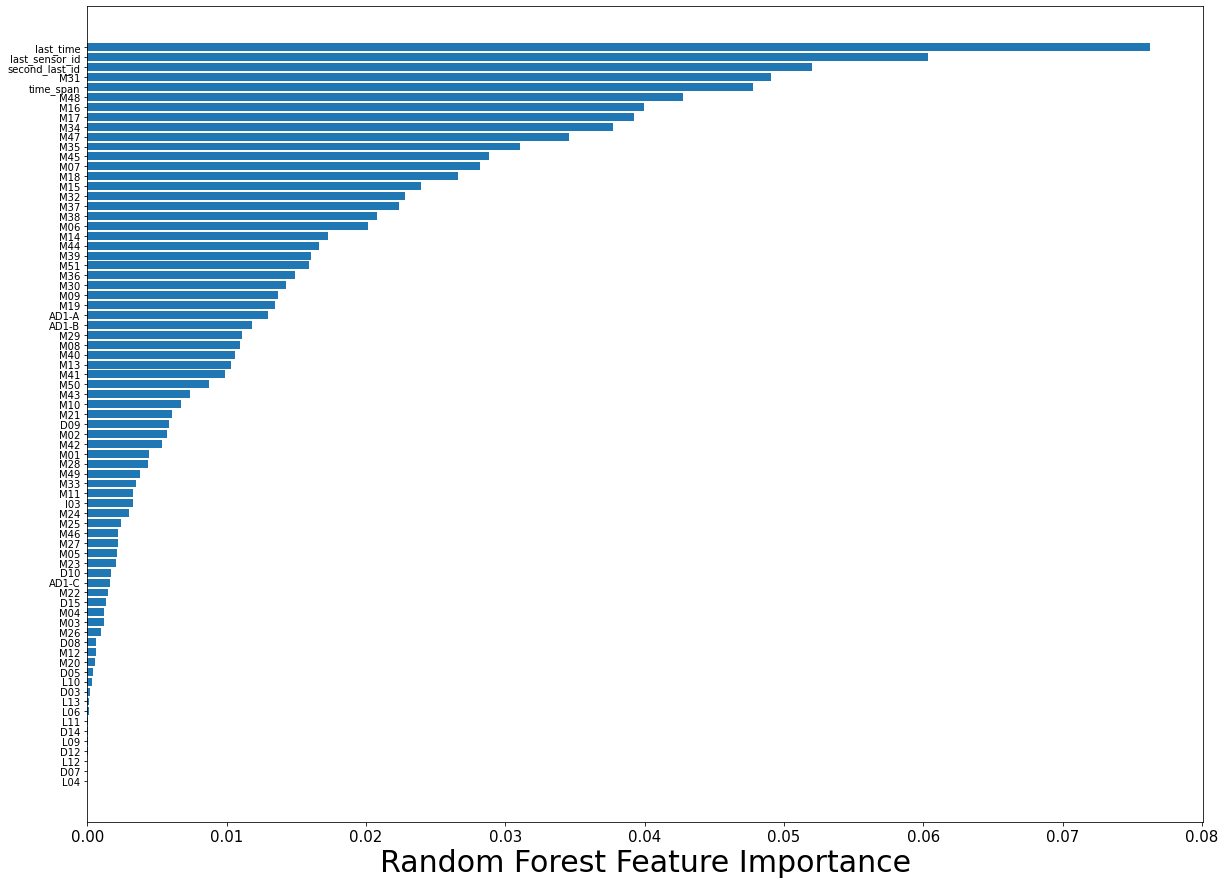

In [49]:
score, _, feature_importances = RF_Classifier(X_train, X_test, y_train, y_test, feature_names = feature_names, n_estimators=300)

In [43]:
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
import json

# To get the importance according to each class:
def class_feature_importance(X, Y, feature_importances, df):
    _, M = np.array(X_train).shape #有 M = 75 列
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    # X_scaled = X

    out = {}
    for c in set(sorted(df.activity.unique())):
        out[c] = dict(
            zip(range(M), np.mean(np.array(X_scaled)[np.array(Y) == c, :], axis=0)*feature_importances)
        )

    return out

# labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
result = class_feature_importance(X_train, y_train, feature_importances, df)

for a in result:
    print(a, result[a])
    print("\n")


0 {0: 6.826952271838944e-07, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 2.6345774553165003e-05, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0006058209829984132, 21: 0.00041973327499048095, 22: 0.00015217304546123828, 23: 0.00011012458062254105, 24: 2.098515422582259e-05, 25: 0.0009013874590766682, 26: 0.0014221615244941297, 27: 0.0009038395513666489, 28: 0.000292568865909341, 29: 1.051921639221149e-05, 30: 6.688739413438306e-05, 31: 4.158812087637598e-05, 32: 6.853658421024414e-05, 33: 0.0005231979293505661, 34: 0.0006124721868170619, 35: 0.0007599000948890271, 36: 0.0007454150450610789, 37: 0.0014707368070632145, 38: 0.0012223564541867, 39: 7.506648813709928e-06, 40: 0.0009742592191003441, 41: 0.00014716923944473444, 42: 0.00015367964282975364, 43: 0.00030624378363333177, 44: 0.00024544340451014335, 45: 3.4438039723821046e-05, 46: 3.241574038281936e-05, 47: 1.1654936262283121e-05, 48: 6.594955102653445e-06, 49

In [44]:
np.array(X_train)[np.array(y_train) == 5, :]

array([[4.73372781e-03, 0.00000000e+00, 0.00000000e+00, ...,
        2.09490741e-02, 6.40000000e+01, 6.40000000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.16666667e-03, 6.40000000e+01, 5.00000000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.10416667e-02, 5.00000000e+01, 5.00000000e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.44675926e-03, 5.00000000e+01, 3.20000000e+01],
       [2.84023669e-01, 0.00000000e+00, 5.91715976e-02, ...,
        6.92013889e-02, 5.10000000e+01, 5.10000000e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.08680556e-02, 5.00000000e+01, 5.00000000e+01]])

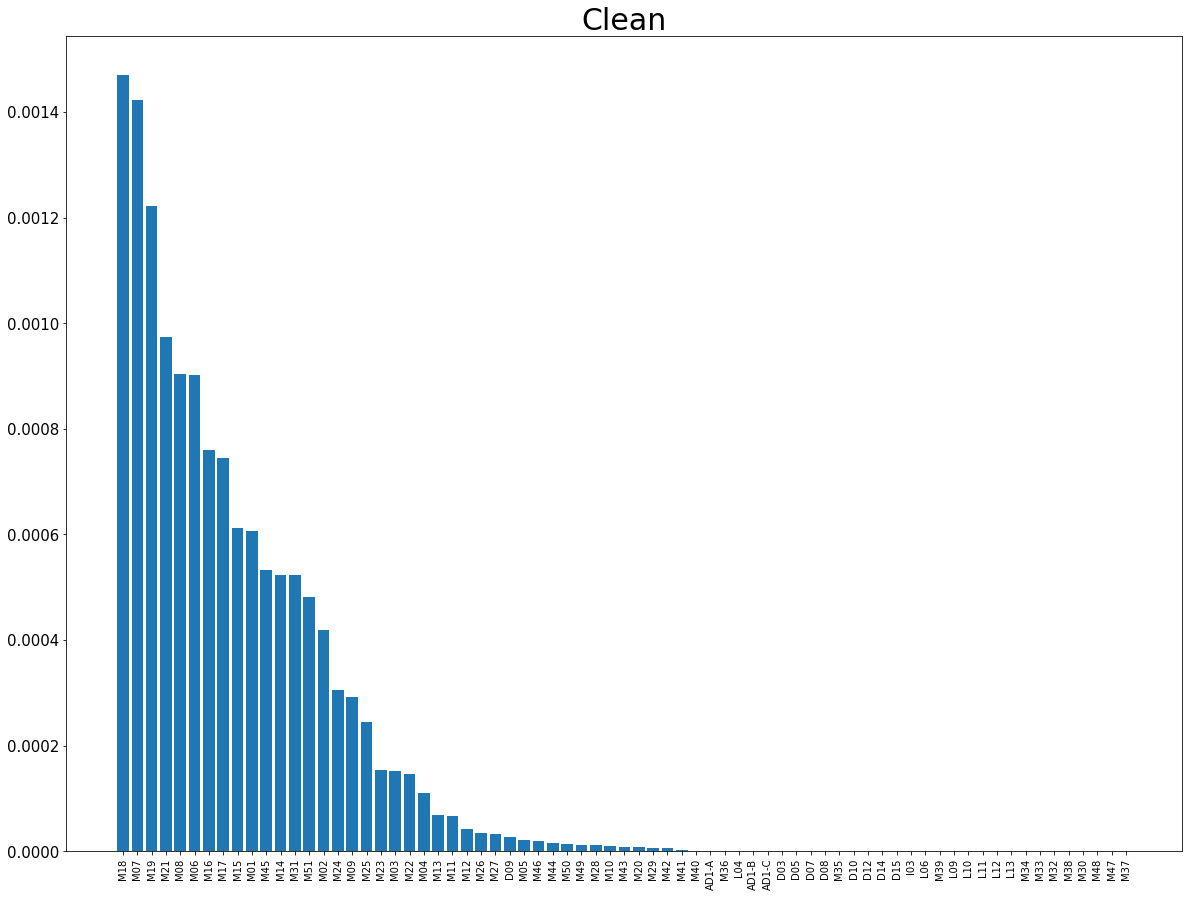

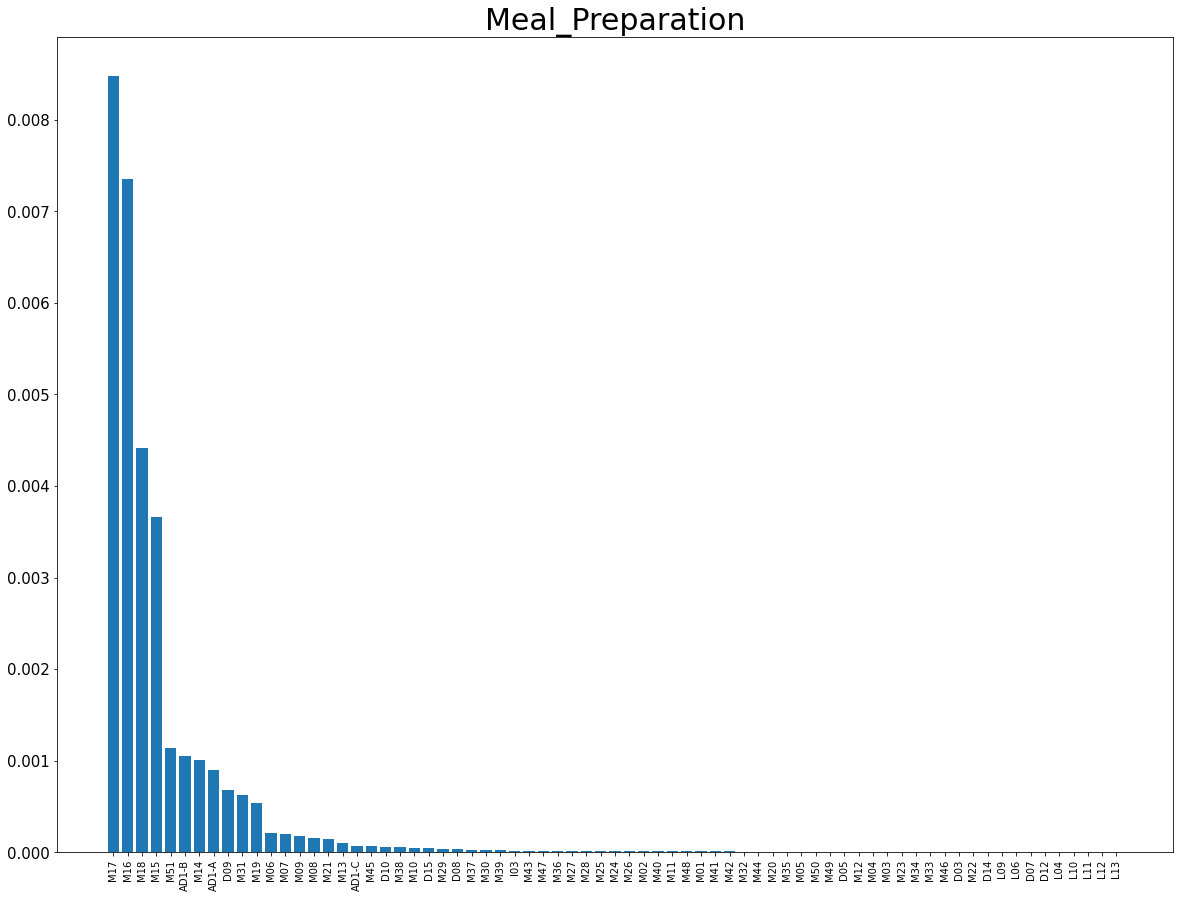

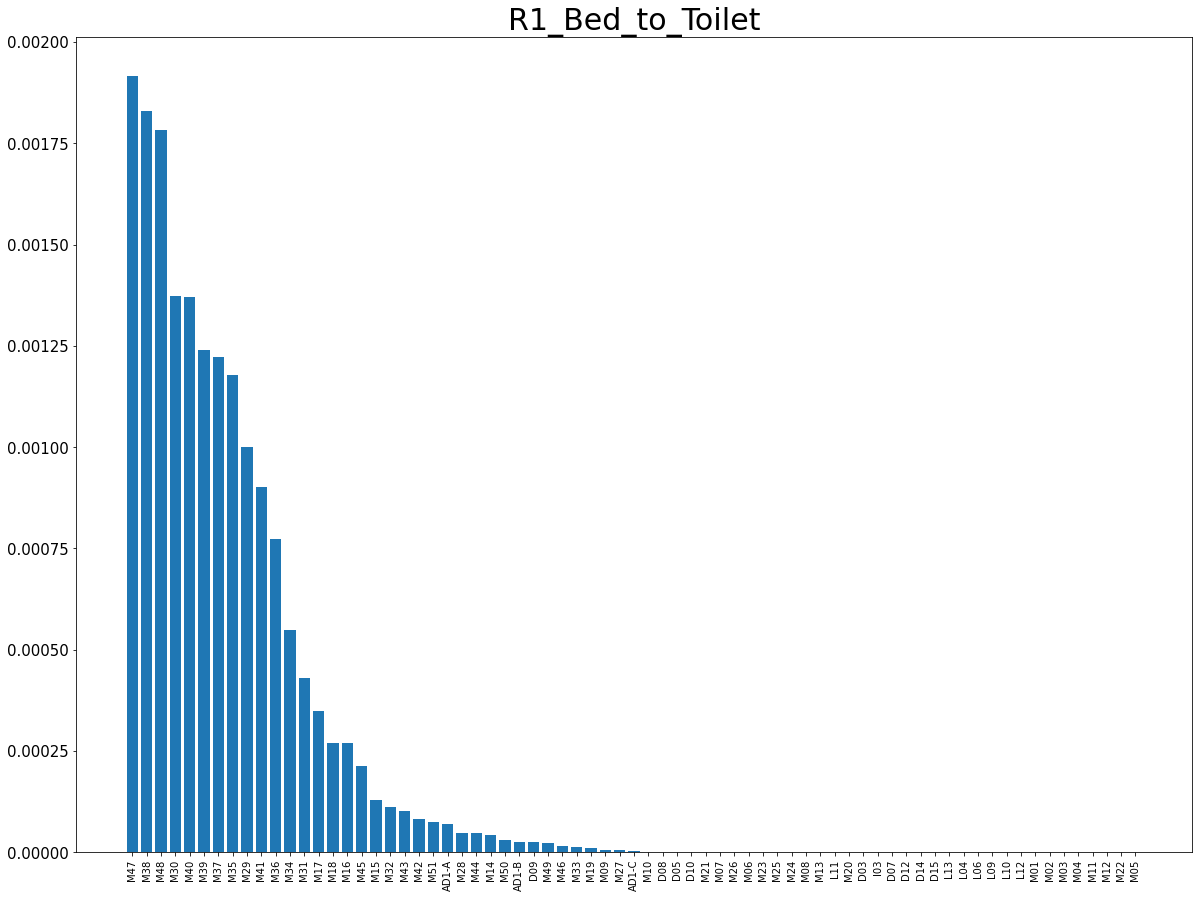

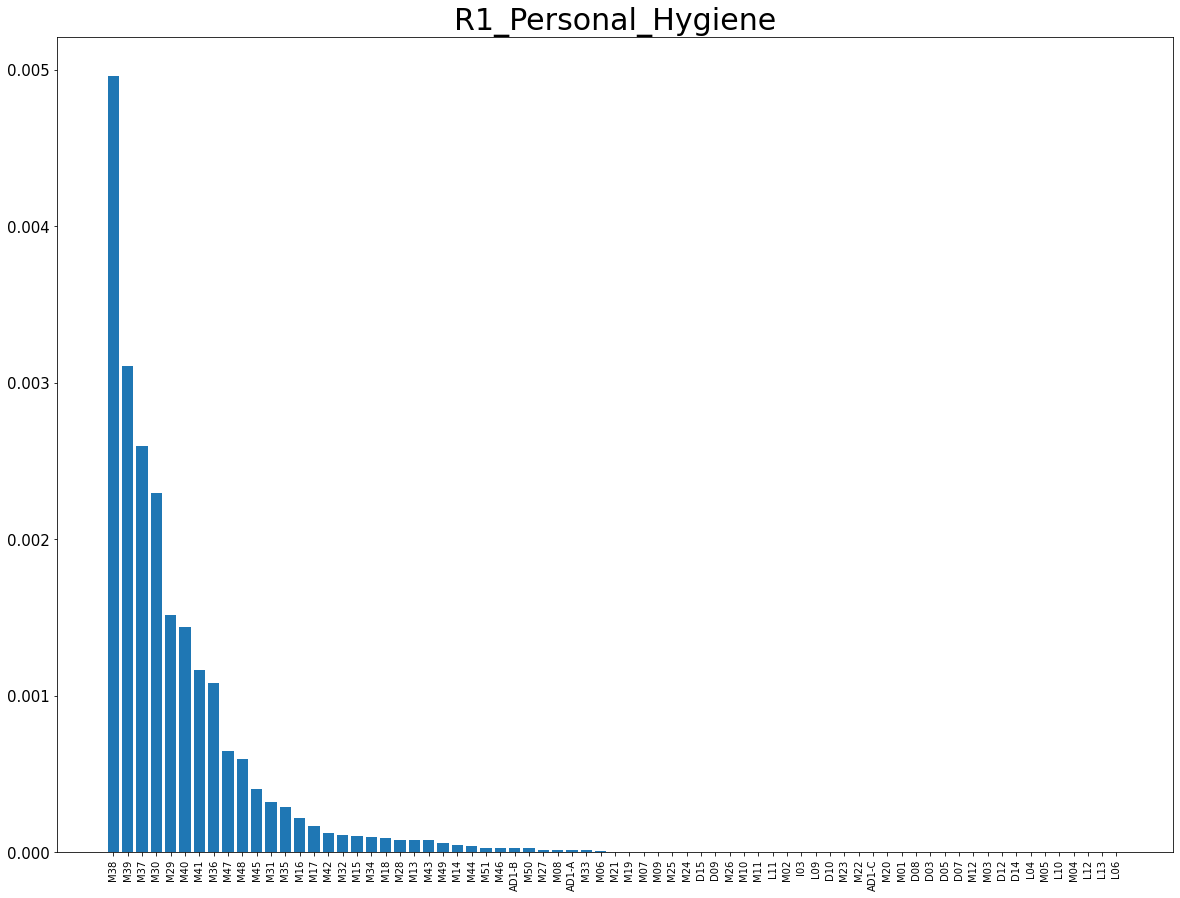

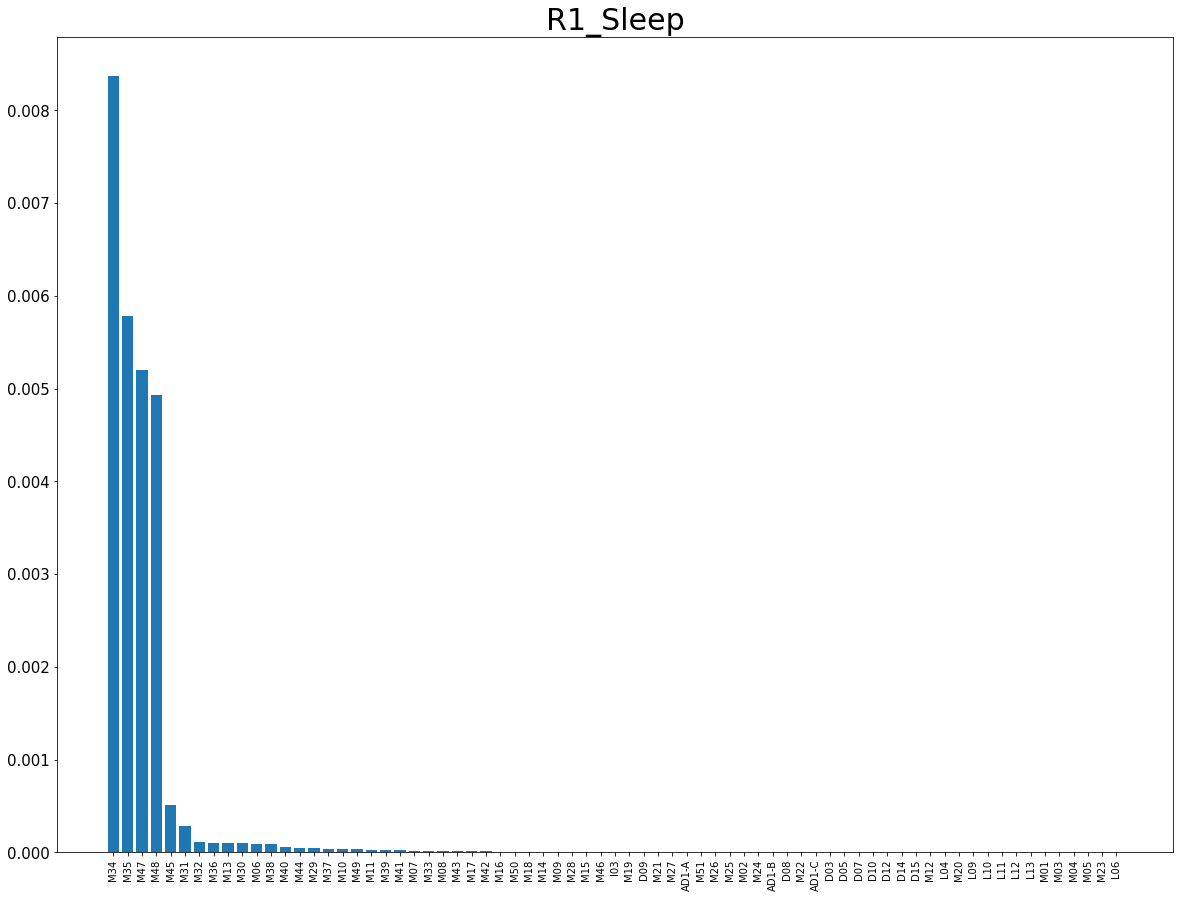

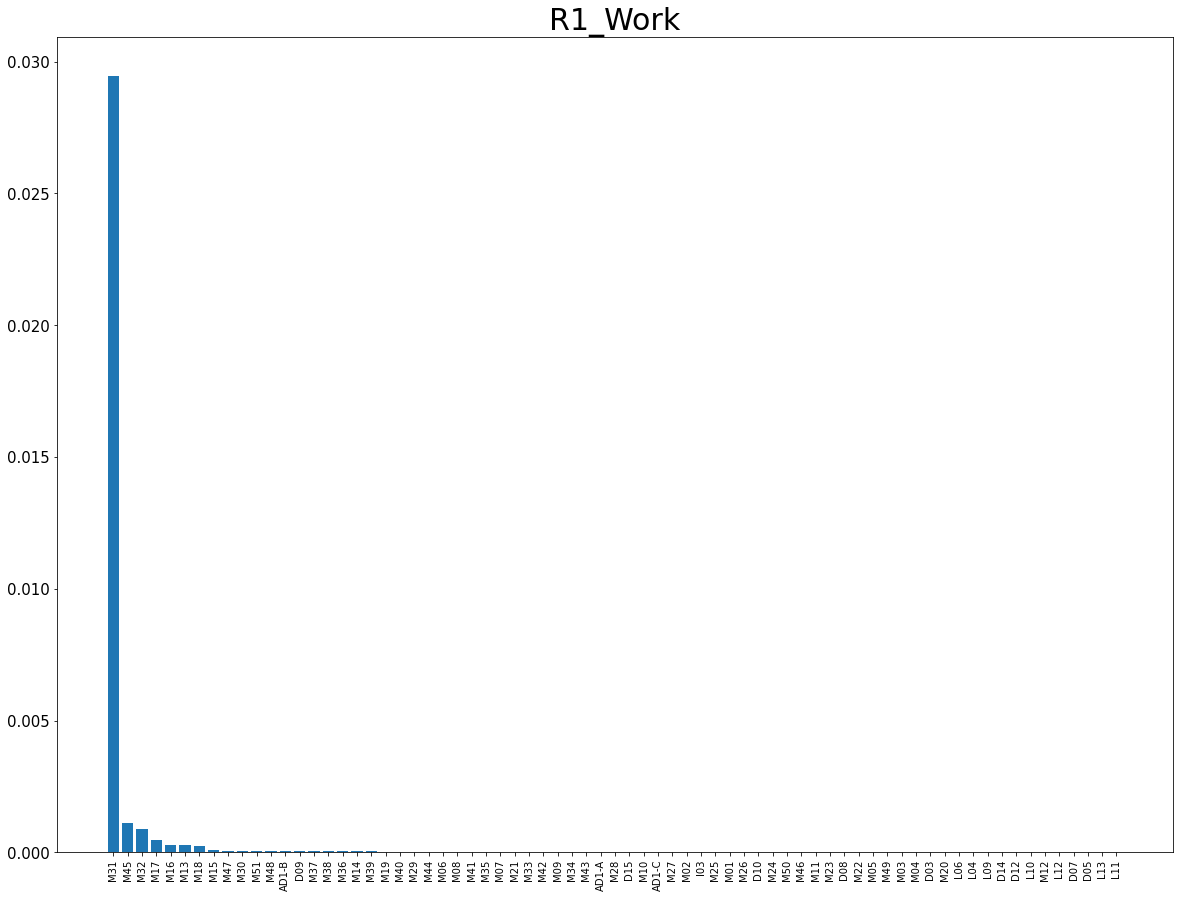

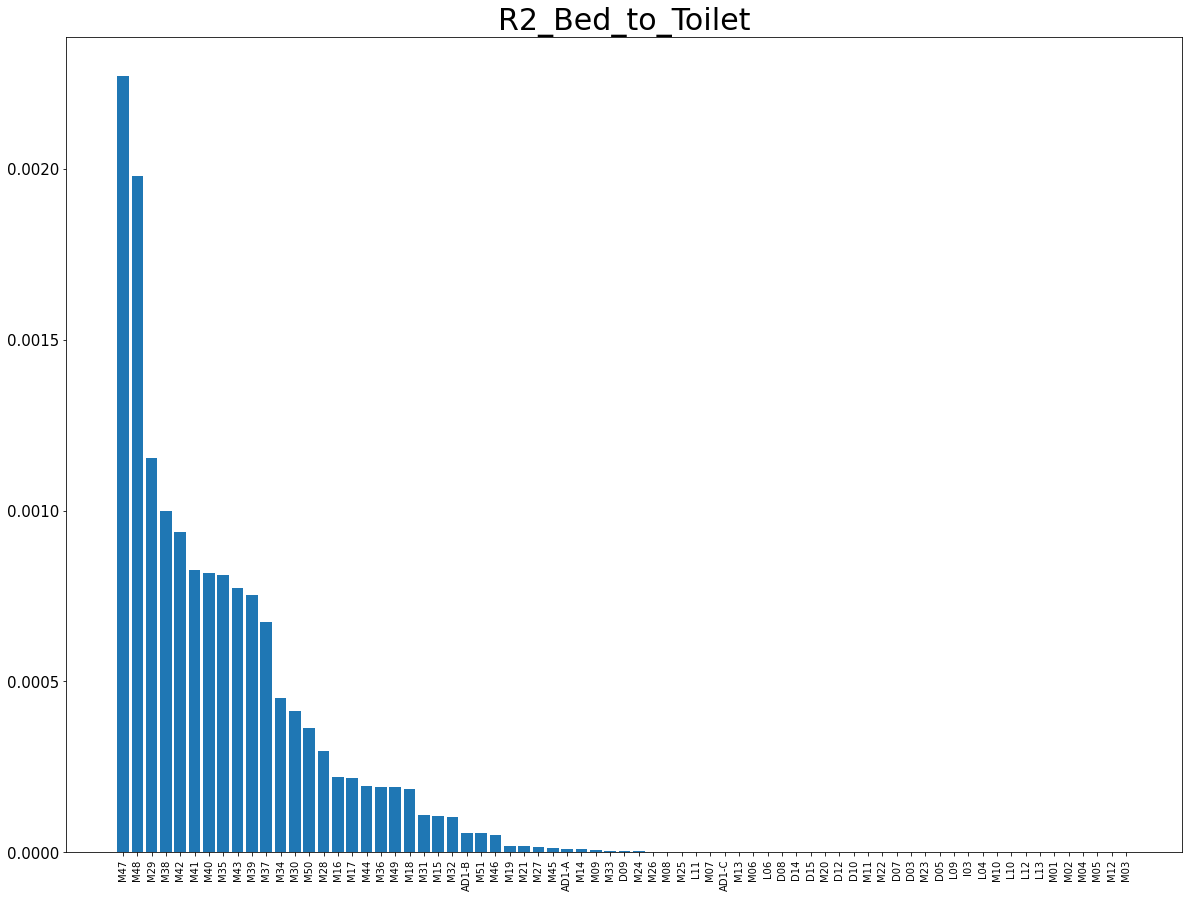

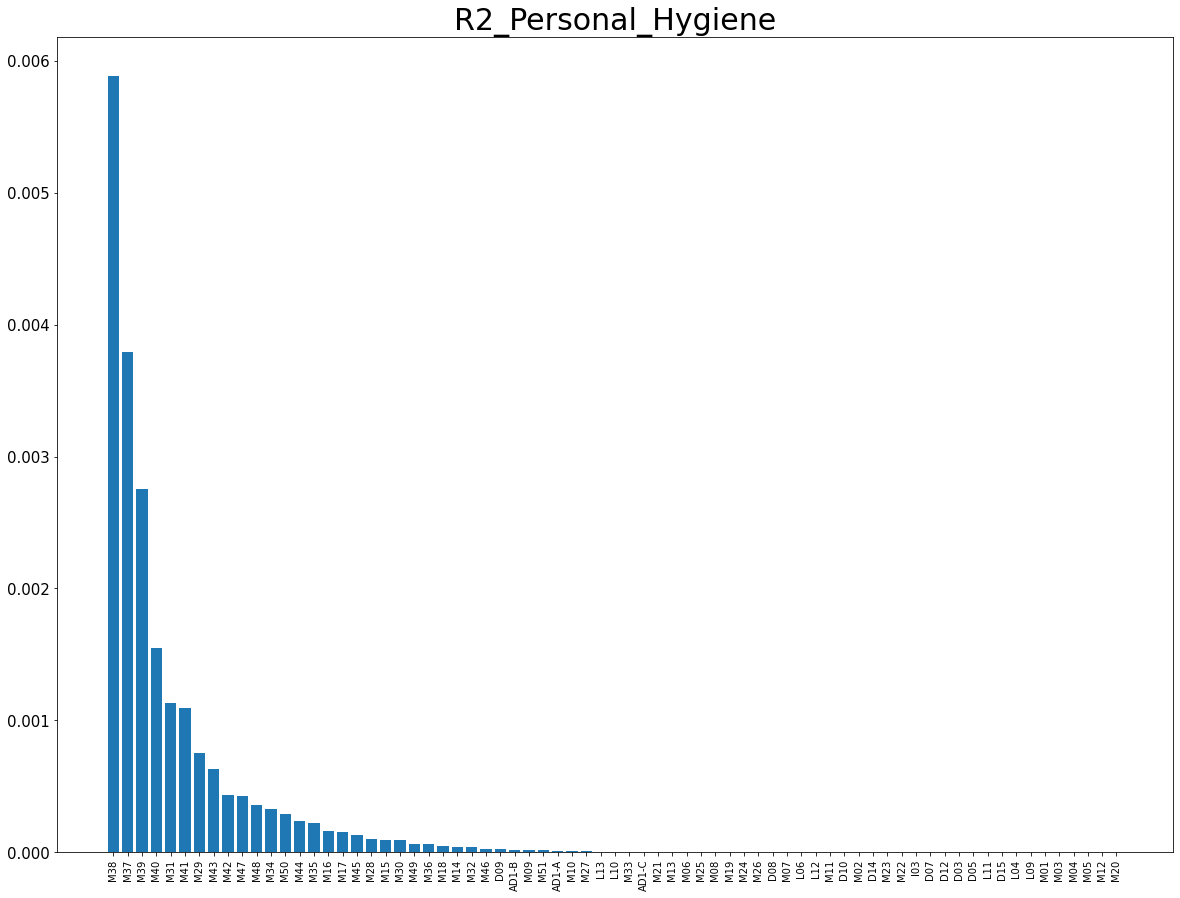

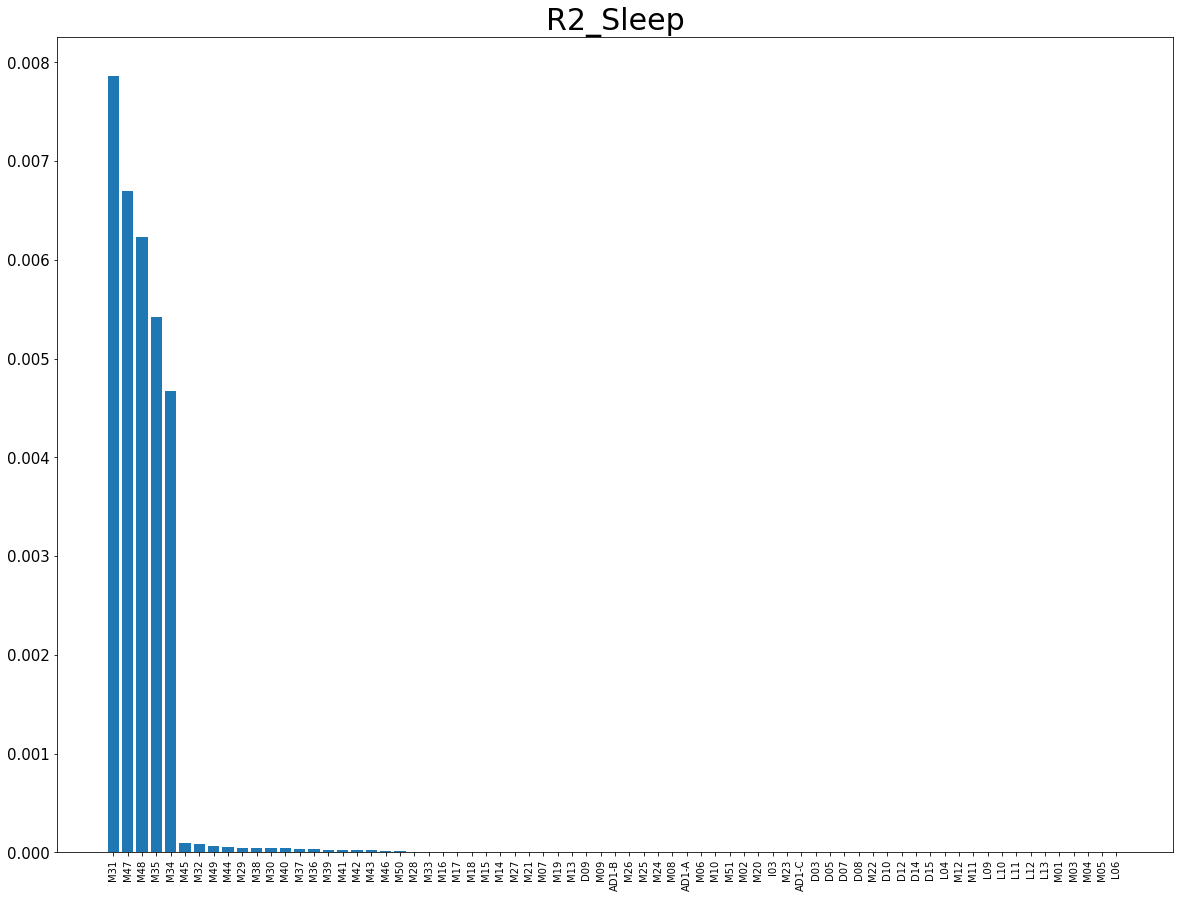

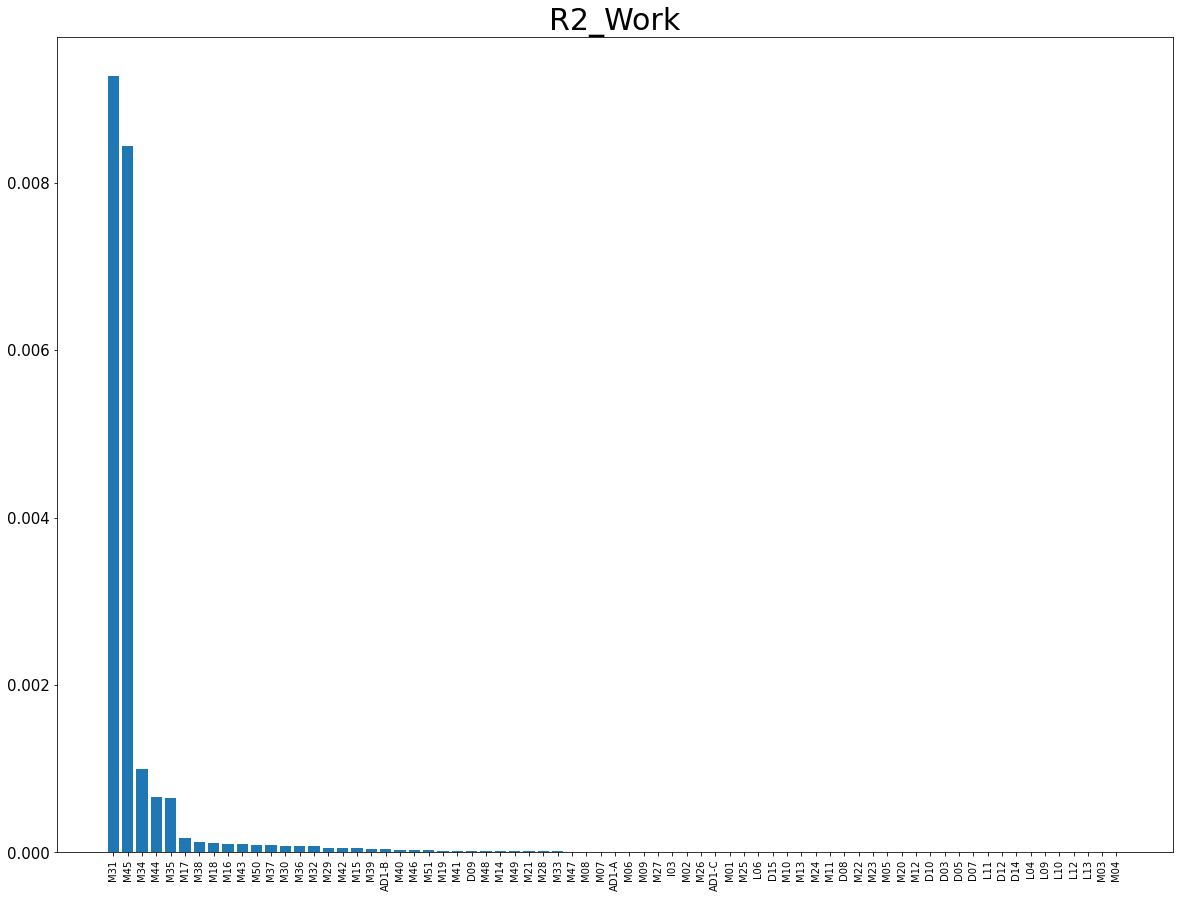

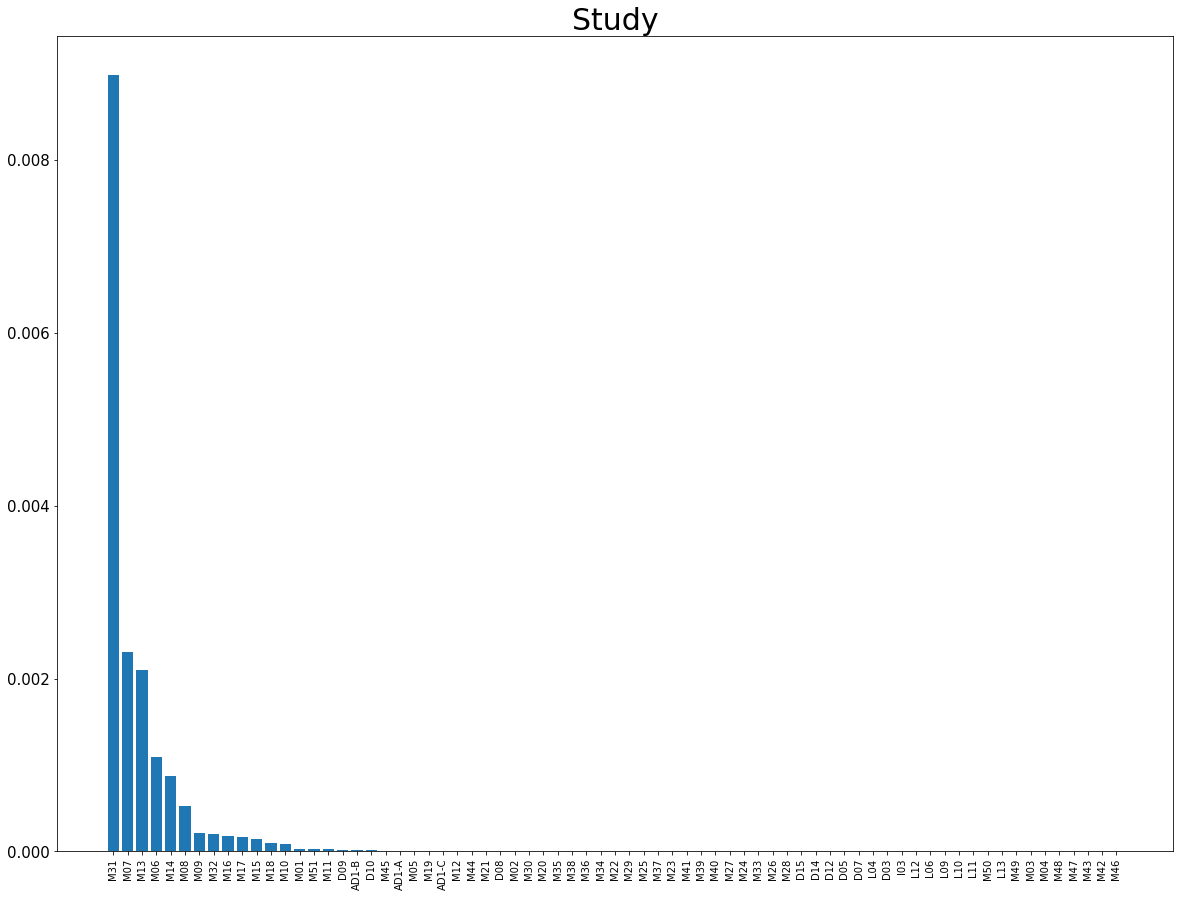

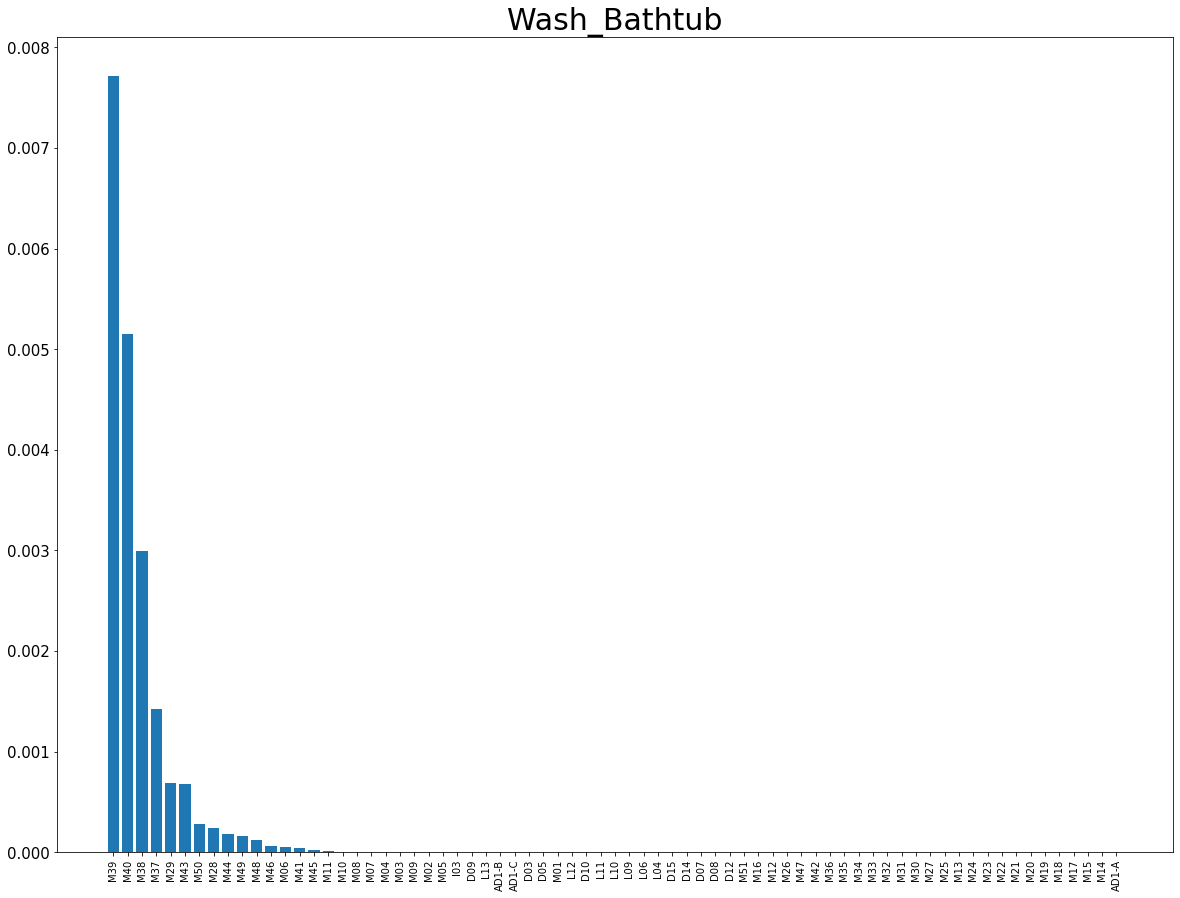

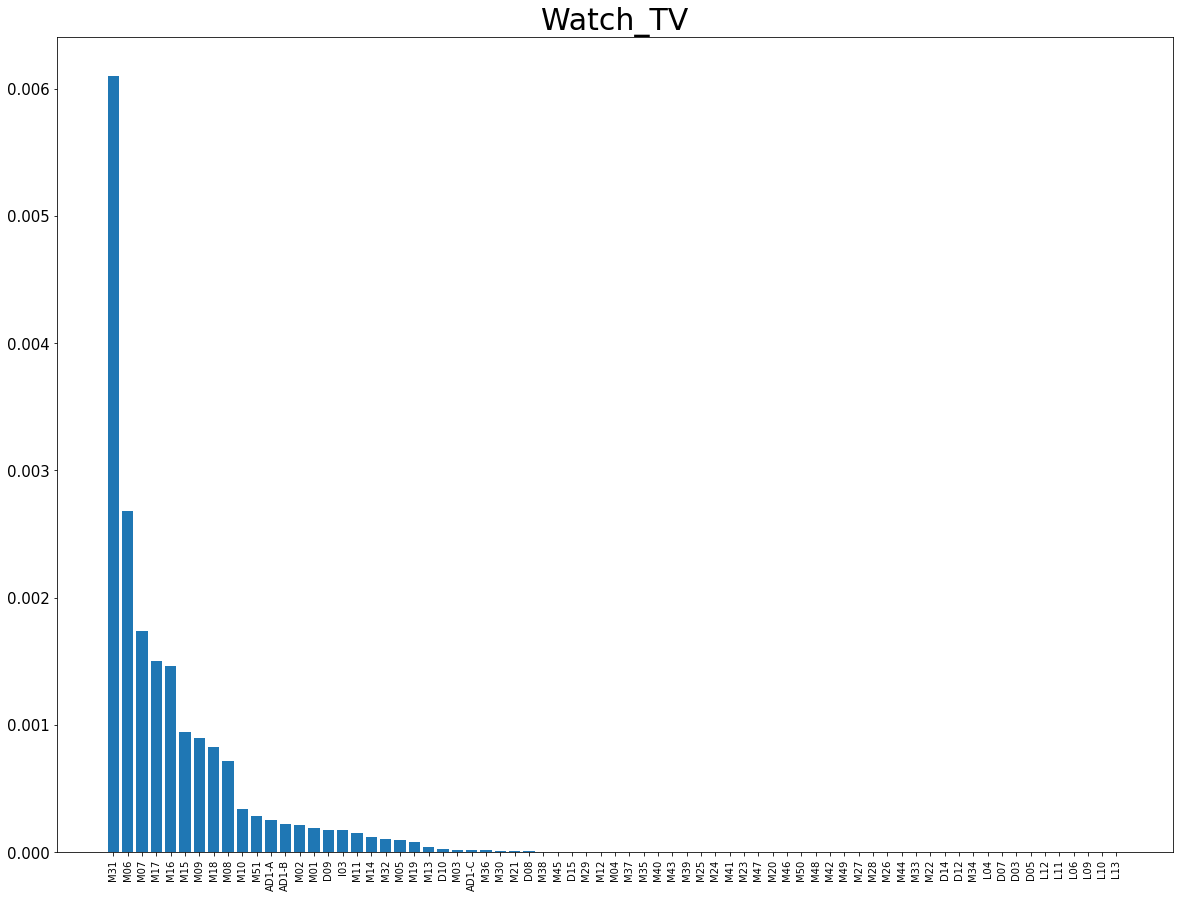

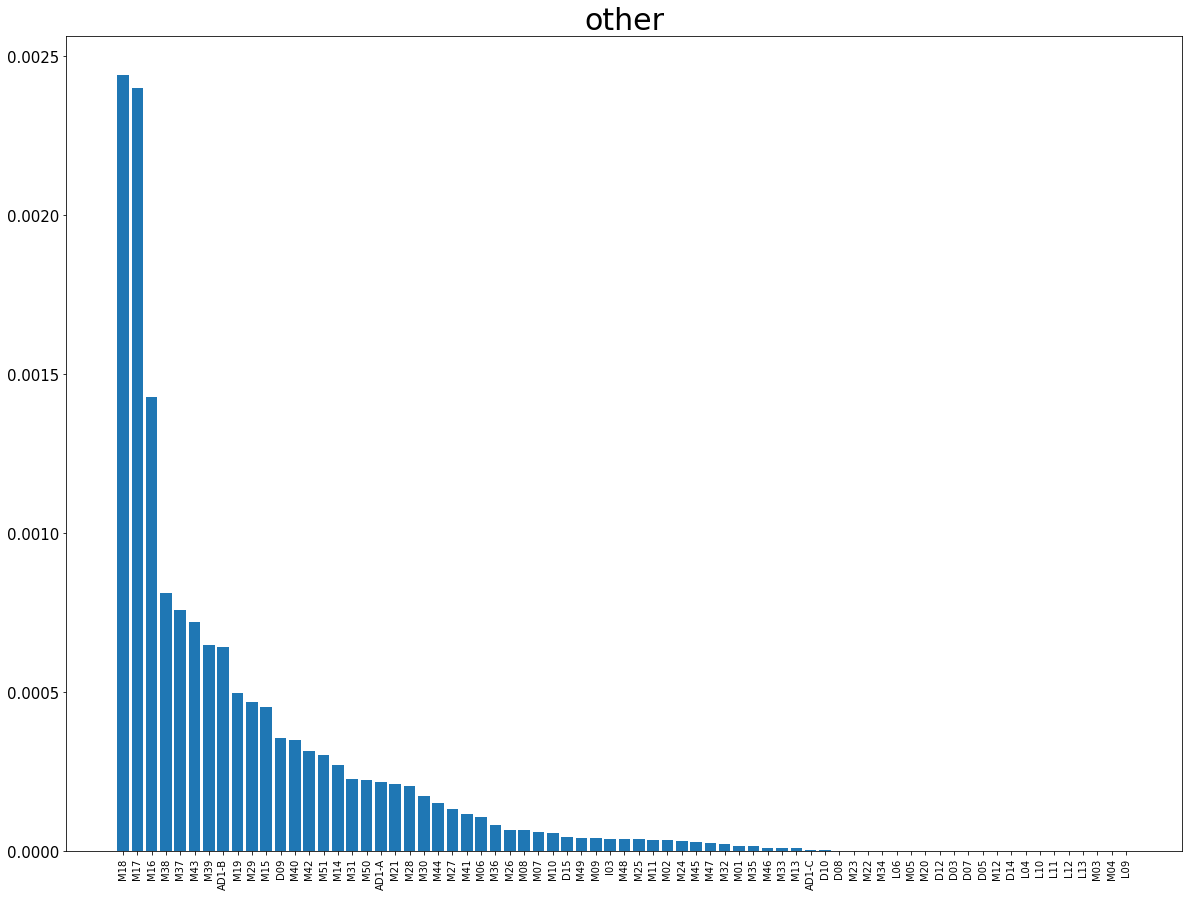

In [52]:
for label_index in range(len(result)):
    plt.figure(figsize=(20,15))

    title = str(activity_encoder.inverse_transform(sorted(df.activity.unique()))[label_index])
    plt.title(title, fontsize = 30)

    sorted_indices = np.argsort(list(result[label_index].values())[:71])[::-1] #降序indices


    values = [list(result[label_index].values())[idx] for idx in sorted_indices]
    plt.bar(np.array(feature_names)[sorted_indices], values)
           # color="r", align="center")
    plt.xticks(rotation=90)
    # plt.xlim([-1, len(result[i])])
    plt.tick_params(axis='y', labelsize = 15)
    plt.savefig("images_ActivityRecognition/importance_per_activity/" + title + ".pdf")

In [46]:
# print(np.argsort(list(result[0].values())))
# print(list(result[0].values()))
